In [1]:
import numpy as np
import h5py
import os
import glob
from utilityFunctions import load_csv_to_matrix, load_csv_to_matrix_batch, compute_color_preference_raw_batch, compute_color_preference_distance_batch, show_heatmaps, compute_color_similarity_distance_batch, compute_correlations, RSA, split_and_average_matrices, perform_mds_and_plot
from utilityFunctions_GWOT import GWD_and_find_best, GWD_and_plot

In [2]:
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)
folder_path = 'raw_data/202411_data'
response_type = 'preference'

In [3]:
def load_clusters_from_mat_v73(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys:", list(f.keys()))  # Inspect available variables

        clusters = f['clusters']
        # Assume it's a 2x1 cell array, and each cell points to a dataset
        cluster1_ref = clusters[0][0]
        cluster2_ref = clusters[1][0]

        cluster1 = np.array(f[cluster1_ref]).astype(int).flatten()
        cluster2 = np.array(f[cluster2_ref]).astype(int).flatten()

        return cluster1, cluster2

In [4]:
cluster1, cluster2 = load_clusters_from_mat_v73('raw_data/clusters_preference_raw.mat')
print(cluster1)
print(cluster2)

Keys: ['#refs#', 'clusters', 'participants', 'process_type', 'rating_type']
[ 1 15 12  7 11  5  8 10  4 13 18]
[ 2 19  6  3 16  9 14 17]


In [5]:
cluster_1_matrices = []
for subject_id in cluster1:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_1_matrices.append(matrix)

cluster_1_matrices_raw_preference = compute_color_preference_raw_batch(cluster_1_matrices, value_range_max = 3.5)

cluster_2_matrices = []
for subject_id in cluster2:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_2_matrices.append(matrix)

cluster_2_matrices_raw_preference = compute_color_preference_raw_batch(cluster_2_matrices, value_range_max = 3.5)

In [6]:
stacked_1 = np.stack(cluster_1_matrices_raw_preference)  # Shape: (n_subjects, matrix_size, matrix_size)
cluster_1_mean_raw_preference = np.mean(stacked_1, axis=0)

stacked_2 = np.stack(cluster_2_matrices_raw_preference)  
cluster_2_mean_raw_preference = np.mean(stacked_2, axis=0)

In [7]:
### GWOT configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

/opt/anaconda3/envs/condapreferencequalia/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Best epsilon: 0.04000000000000001, Minimum GWD: 0.742


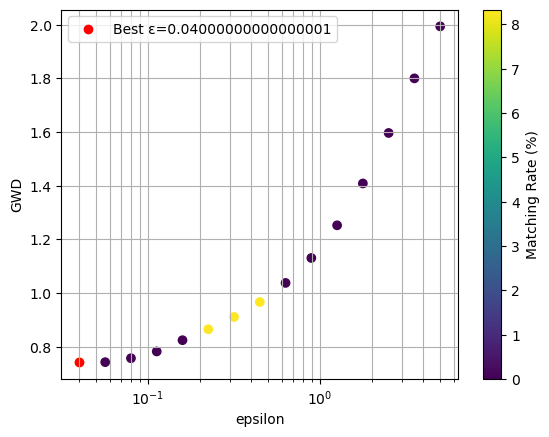

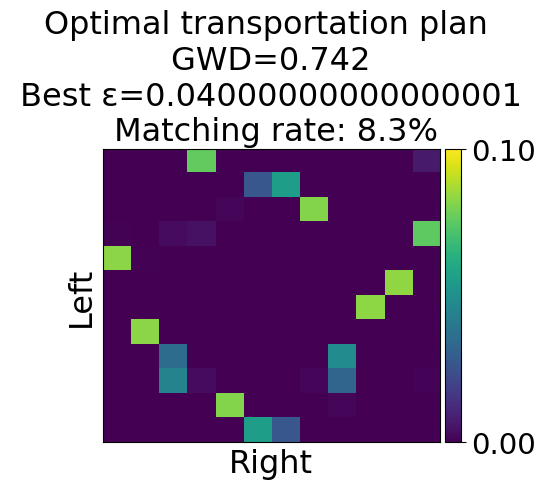

(array([[1.65821981e-017, 1.28376164e-050, 5.89535906e-015,
         7.59391130e-002, 2.41149855e-005, 1.84930103e-011,
         5.12002517e-008, 5.21862273e-006, 2.19982598e-004,
         2.32585121e-047, 1.45537537e-080, 7.14485295e-003],
        [9.77848154e-027, 2.42737619e-064, 6.57955146e-028,
         3.79446778e-011, 7.79517982e-006, 2.72430122e-002,
         5.60823534e-002, 5.42186171e-008, 2.80712869e-010,
         1.61266944e-071, 1.04182766e-108, 1.18035499e-007],
        [5.72985828e-026, 4.25551718e-054, 1.27323316e-021,
         6.22317104e-009, 1.80943433e-003, 1.67282381e-007,
         1.83449616e-006, 8.15216666e-002, 2.24361406e-007,
         1.38541425e-057, 2.42348085e-094, 7.17248952e-012],
        [6.31848715e-004, 3.49833567e-014, 2.89866875e-003,
         4.37670874e-003, 2.29178175e-010, 2.27482892e-027,
         3.54524501e-022, 1.90934187e-005, 3.17093933e-004,
         3.48806793e-018, 5.82514254e-036, 7.50899196e-002],
        [8.26044267e-002, 6.37482535

In [8]:
GWD_and_plot(cluster_1_mean_raw_preference, cluster_2_mean_raw_preference, epsilons)